<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC581B - Introduction to Deep Learning for Image Classification
# Final Project - Linear Classifier

In [1]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random


First we need to load the training and test data.

In [2]:
normalize_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
])

In [3]:
# Load the training data (CIFAR10 to start)
training_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
training_targets = training_data.targets

In [5]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [6]:
batch_size = 200

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(training_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [7]:
# Check that it is splitting the data properly
train_length = 0
for _, y in train_dataloader:
  train_length += len(y)
print(f"Length of training split: {train_length}")

valid_length = 0
for _, y in valid_dataloader:
  valid_length += len(y)
print(f"Length of validation split: {valid_length}")

test_length = 0
for _, y in test_dataloader:
  test_length += len(y)
print(f"Length of test split: {test_length}")

Length of training split: 40000
Length of validation split: 10000
Length of test split: 10000


In [8]:
# Check that there are 100 instances of each class in the validation set
count = 0
for _, y in valid_dataloader:
  for target in y:
    if int(target.numpy()) == 0:
      count += 1

print(count)

100


## Building some linear models

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [10]:
# Define the model
class LinearModel(nn.Module):
  def __init__(self, n_neurons):
    super(LinearModel, self).__init__()
    self.name = f'model_{n_neurons}'
    self.flatten = nn.Flatten()
    self.linear_model = nn.Sequential(
        nn.Linear(32*32*3, n_neurons),
        nn.Linear(n_neurons, n_neurons),
        nn.Linear(n_neurons, 100),
    )

  # Forward propagation function
  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_model(x)
    return x

In [11]:
# Training loop
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track train_loss and accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [12]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [ ]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [20]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step()

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')

  return train_losses, train_accuracies, val_losses, val_accuracies

# Training

In [39]:
n_epochs = 20

In [40]:
model_100 = LinearModel(n_neurons=100).to(device)
#print(model_100)

model_500 = LinearModel(n_neurons=500).to(device)
#print(model_500)

model_1000 = LinearModel(n_neurons=1000).to(device)
#print(model_1000)

model_2000 = LinearModel(n_neurons=2000).to(device)
#print(model_2000)

In [41]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer_100 = torch.optim.SGD(model_100.parameters(), lr=1e-1)
optimizer_500 = torch.optim.SGD(model_500.parameters(), lr=1e-1)
optimizer_1000 = torch.optim.SGD(model_1000.parameters(), lr=1e-1)
optimizer_2000 = torch.optim.SGD(model_2000.parameters(), lr=1e-1)

# Learning rate schedulers
scheduler_100 = torch.optim.lr_scheduler.StepLR(optimizer_100, step_size=10, gamma=0.1)
scheduler_500 = torch.optim.lr_scheduler.StepLR(optimizer_500, step_size=10, gamma=0.1)
scheduler_1000 = torch.optim.lr_scheduler.StepLR(optimizer_1000, step_size=10, gamma=0.1)
scheduler_2000 = torch.optim.lr_scheduler.StepLR(optimizer_2000, step_size=10, gamma=0.1)

In [42]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model_100, train_dataloader, valid_dataloader,
              batch_size, loss_fn, optimizer_100, scheduler=scheduler_100, early_stopping=False, patience=10)


Epoch 1
----------------------------
loss: 4.645518 [    0/40000]
loss: 3.942276 [20000/40000]
Validation Error: 
 Validation accuracy: 13.2%, Validation loss: 3.836209 


Epoch 2
----------------------------
loss: 3.766306 [    0/40000]
loss: 3.651538 [20000/40000]
Validation Error: 
 Validation accuracy: 16.1%, Validation loss: 3.719167 


Epoch 3
----------------------------
loss: 3.638145 [    0/40000]
loss: 3.736180 [20000/40000]
Validation Error: 
 Validation accuracy: 16.8%, Validation loss: 3.683603 


Epoch 4
----------------------------
loss: 3.702989 [    0/40000]
loss: 3.450701 [20000/40000]
Validation Error: 
 Validation accuracy: 16.5%, Validation loss: 3.674678 


Epoch 5
----------------------------
loss: 3.564422 [    0/40000]
loss: 3.432955 [20000/40000]
Validation Error: 
 Validation accuracy: 17.4%, Validation loss: 3.650725 


Epoch 6
----------------------------
loss: 3.398281 [    0/40000]
loss: 3.251561 [20000/40000]
Validation Error: 
 Validation accuracy: 17.

<function matplotlib.pyplot.show>

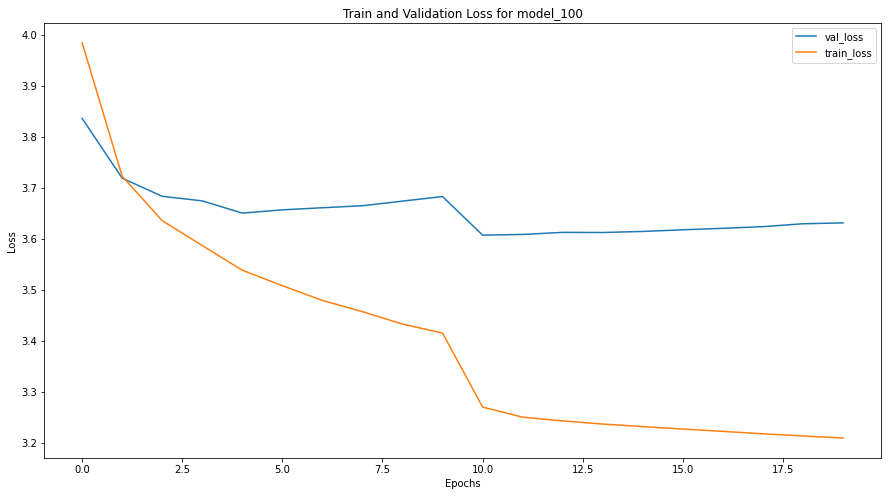

In [43]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_100.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

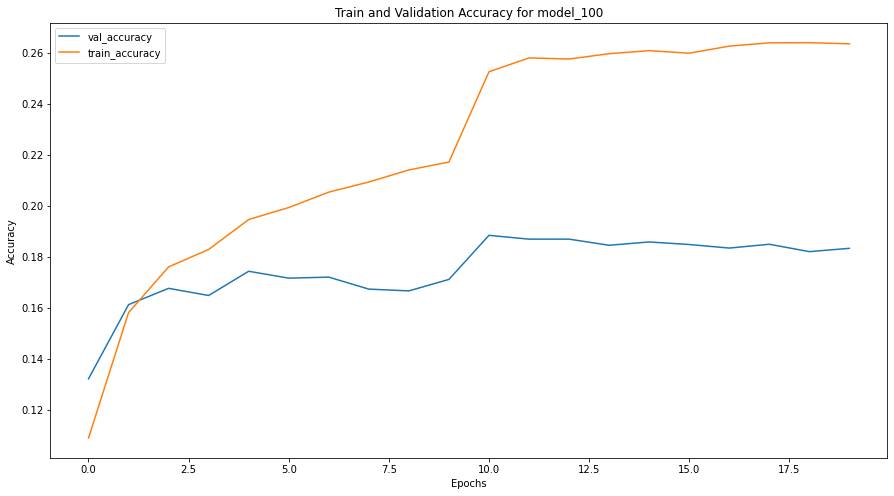

In [44]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_100.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model_500, train_dataloader, valid_dataloader,
              batch_size, loss_fn, optimizer_500, scheduler=scheduler_500, early_stopping=False, patience=10)

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_500.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_500.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model_1000, train_dataloader, valid_dataloader,
              batch_size, loss_fn, optimizer_1000, scheduler=scheduler_1000, early_stopping=False, patience=10)


Epoch 1
----------------------------
loss: 4.627542 [    0/40000]
loss: 4.462950 [10000/40000]
loss: 4.256098 [20000/40000]
loss: 3.947877 [30000/40000]
Validation Error: 
 Accuracy: 2.0%, Avg loss: 3.993850 


Epoch 2
----------------------------
loss: 3.953144 [    0/40000]
loss: 3.753744 [10000/40000]
loss: 3.752641 [20000/40000]
loss: 3.708488 [30000/40000]
Validation Error: 
 Accuracy: 2.4%, Avg loss: 3.856921 


Epoch 3
----------------------------
loss: 3.947703 [    0/40000]
loss: 4.088981 [10000/40000]
loss: 3.892617 [20000/40000]
loss: 3.756453 [30000/40000]
Validation Error: 
 Accuracy: 2.9%, Avg loss: 3.769571 


Epoch 4
----------------------------
loss: 3.425246 [    0/40000]
loss: 3.935998 [10000/40000]
loss: 3.888884 [20000/40000]
loss: 3.740047 [30000/40000]
Validation Error: 
 Accuracy: 2.7%, Avg loss: 3.805315 


Epoch 5
----------------------------
loss: 4.044482 [    0/40000]
loss: 3.699428 [10000/40000]
loss: 3.784934 [20000/40000]
loss: 3.707857 [30000/40000]
Va

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_1000.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_1000.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model_2000, train_dataloader, valid_dataloader,
              batch_size, loss_fn, optimizer_2000, scheduler=scheduler_2000, early_stopping=False, patience=10)

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_2000.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_2000.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show